In [17]:
!pip install geopy
!pip install folium

from geopy.geocoders import Nominatim
import pandas as pd 
import numpy as np
import re
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import folium

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [3]:
# Convert a bunch of addresses to longitude latitude coordinates
geolocator = Nominatim(user_agent = "CSESoc_locator")

def get_coordinates(address):
    location = geolocator.geocode(address, timeout = 10)
    time.sleep(1.5)
    if location:
        return location.latitude, location.longitude
    return None, None

def app_state_country(address):
    # Checks for NSW in any format or case
    has_nsw = re.search(r"\b(?:NSW|New South Wales)\b", address, re.IGNORECASE)
    # Checks for Australia in any format or case
    has_aus = re.search(r"\b(Australia)\b", address, re.IGNORECASE)

    if has_nsw and not has_aus: 
        address += ", Australia"
    elif not has_nsw and not has_aus: 
        address += ", NSW, Australia"
    elif not has_nsw and has_aus:
        address = re.sub(r"\bAustralia\b$", "NSW, Australia", address, flags = re.IGNORECASE)
    return address 

# Test (assume post-cleaning): Delete later
data = {
    "Name": ["Alex", "Bella", "Chris", "Dana", "Eli", "Faith", "George", "Holly", "Ivan", "Jill", "Kurt", "Lara", "Megan", 
             "Nina", "Oscar", "Paul", "Quincy", "Rita", "Sam", "Tina", "Uma", "Victor", "Wendy", "Xander", "Yara", "Zara", 
             "Aaron", "Beth", "Cathy", "Dean", "Emily", "Fay", "Gary", "Hannah", "Ivy", "Jack", "Kenny", "Lucy", "Marty", 
             "Nash", "Olivia", "Penny", "Quinn", "Rose", "Steve", "Tom", "Ursula", "Vince", "Will", "Xena", "Bob", "Declan",
             "Thomas", "Ewan", "Harley", "Jacky", "Lionel", "Ka", "Rory", "Pip", "Tyrone", "Glenn", "Jim", "Li", "Wong", "Ye"],
    "Address": [
        "315/1 Network Place, North Ryde",
        "12 Mahon St, West Ryde",
        "1 Macarthur St, Parramatta",
        "1 Patterson Avenue, West Pymble",
        "140 George St, The Rocks, NSW, Australia",
        "48 Alfred St, Milsons Point",
        "7 Rowe St, Eastwood, NSW",
        "50 John St, Liverpool",
        "12 Green St, Banksmeadow, Australia",
        "9 Harris St, Fairfield",
        "2 Hadenfeld Avenue, Macquarie Park, NSW",
        "10 Marsden Rd, West Ryde",
        "42 Railway Parade, Burwood",
        "100 Woodville Rd, Merrylands",
        "34 Queens Rd, Hurstville, NSW",
        "1 Long St, Strathfield, Australia",
        "10 Dawson St, Epping, NSW",
        "22 Kingsway, Cronulla, NSW",
        "1 Smith St, Tempe, NSW",
        "10 Bay St, Rockdale, NSW",
        "301 Botany Rd, Zetland, Australia",
        "1 Anderson St, Mortdale, Australia",
        "20 Stoney Creek Rd, Beverly Hills, NSW",
        "12 Oatley Ave, Oatley, NSW",
        "26 King St, Newtown",
        "14 William St, Paddington",
        "8 Campbell St, Surry Hills",
        "95 George St, Marrickville",
        "6-10 Wentworth Park Rd, Glebe",
        "25-29 Balfour St, Chippendale",
        "19 Addison Rd, Marrickville",
        "24 Parramatta Rd, Camperdown",
        "30 George St, Redfern",
        "2 Station St, Hornsby, NSW",
        "56 Bridge Rd, Glebe",
        "15 Liverpool St, Darlinghurst",
        "11 Forbes St, Woolloomooloo",
        "12 Fitzroy St, Surry Hills",
        "21 Randle St, Surry Hills",
        "13 Miller St, North Sydney",
        "5 Kent Rd, North Ryde, Australia",
        "3 Bridge Rd, North Sydney",
        "12 Victoria Rd, Rozelle",
        "22 Church St, Pymble",
        "5 Miller St, Pyrmont",
        "10 Sir John Young Crescent, Woolloomooloo",
        "1 Victoria Avenue, Chatswood",
        "13 Lennox St, Gordon, NSW",
        "6 Archer St, Chatswood, Australia",
        "100 Lane Cove Road, Ryde, NSW",
        "5 Wigram St, Harris Park, NSW",
        "10 Hunter St, Parramatta, Australia",
        "5 Isabella St, North Parramatta, NSW",
        "1 Central Avenue, Westmead",
        "1 South St, Granville",
        "1 Pine Rd, Auburn",
        "3 Marco Avenue, Revesby, NSW",
        "12 Tower St, Panania, NSW",
        "2 Edward St, Kingsgrove",
        "313 Mowbray Rd, Chatswood",
        "3 Jersey Rd, Artarmon",
        "1 Nelson Rd, North Strathfield",
        "2 John St, Cabramatta",
        "4 Torrens St, Canley Heights, NSW",
        "6 Spencer St, Fairfield, Australia",
        "1 Wyong St, Canley Heights"
    ],
    "Attendance_Weight": [5, 1, 4, 3, 2, 5, 4, 5, 3, 2, 4, 5, 3, 5, 4, 3, 2, 5, 4, 3, 5, 2, 4, 5, 4, 3, 1, 5, 4, 4, 2, 5, 3, 
                          5, 4, 3, 4, 5, 3, 2, 1, 3, 4, 5, 3, 5, 4, 2, 5, 5, 2, 3, 4, 5, 3, 2, 2, 3, 3, 4, 5, 5, 1, 3, 4, 4]
}

df = pd.DataFrame(data)
df["Cleaned_Address"] = df["Address"].apply(app_state_country)
df[["Latitude", "Longitude"]] = df["Cleaned_Address"].apply(lambda row: pd.Series(get_coordinates(row)))                                                        

In [4]:
df_valid = df.dropna(subset = ["Latitude", "Longitude"]) # Drop invalid addresses

map_center = [df_valid["Latitude"].mean(), df_valid["Longitude"].mean()]
m = folium.Map(location = map_center, zoom_start = 12)

# Add markers to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location = [row["Latitude"], row["Longitude"]],
        radius = row["Attendance_Weight"], # Scale marker size  
        popup = row["Name"],
        color = "purple",
        fill = True,
        fill_opacity = 0.7
    ).add_to(m)

# Save map as HTML
m.save("CSESoc_weighted_map.html")

m

For n_clusters = 3, the average silhouette_score is : 0.5472314183433232
For n_clusters = 4, the average silhouette_score is : 0.5648125960240726
For n_clusters = 5, the average silhouette_score is : 0.5629715709999552
For n_clusters = 6, the average silhouette_score is : 0.5615956128798761
For n_clusters = 7, the average silhouette_score is : 0.5069096504430332
For n_clusters = 8, the average silhouette_score is : 0.5195465796560105
For n_clusters = 9, the average silhouette_score is : 0.47198328801138584
For n_clusters = 10, the average silhouette_score is : 0.4775808294339097


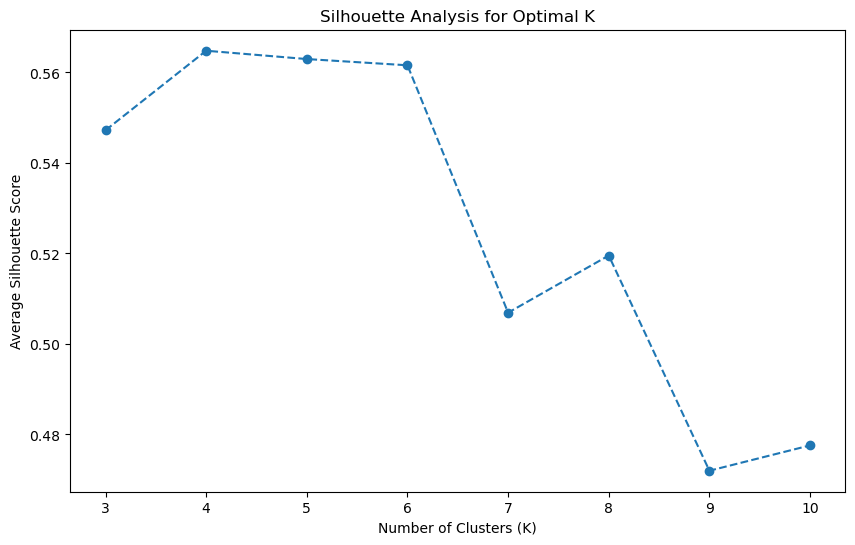

In [9]:
# K-MEANS: Silhouette Score to determine optimal number of clusters
# Normalization 
X = df_valid[['Latitude', 'Longitude']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
for i in range(3, 11):  
    kmeans = KMeans(n_clusters = i, n_init = 1000, random_state = 6)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {i}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), silhouette_scores, marker = 'o', linestyle = '--')
plt.title('Silhouette Analysis for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.show()

In [11]:
# K-MEANS: Clustering
def run_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters, n_init = 1000, random_state = 6)
    kmeans.fit(X)
    return kmeans.labels_, kmeans.cluster_centers_

def visualize_kmeans_on_map(df, n_clusters):
    # To fix the 0 based indexing, for user ease of access
    n_clusters += 1
    
    X = df[['Latitude', 'Longitude']].values  
    labels, centroids = run_kmeans(X, n_clusters)

    # Create Folium map centered around the mean coordinates
    map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
    m = folium.Map(location = map_center, zoom_start = 12)

    colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', '#DC143C', '#7FFF00', '#8B0000', '#C71585', '#20B2AA']

    # Add markers for each data point and color them based on the cluster label
    for i, row in df.iterrows():
        cluster_label = labels[i]
        folium.CircleMarker(
            location = [row['Latitude'], row['Longitude']],
            radius = 6, 
            popup = row['Name'],  
            color = colors[cluster_label % len(colors)],  # Color based on cluster
            fill = True,
            fill_opacity = 0.6
        ).add_to(m)

    # Add centroids as larger icon markers
    for i, centroid in enumerate(centroids):
        folium.Marker(
            location = [centroid[0], centroid[1]],
            popup = f'Centroid {i+1}',
            icon = folium.Icon(color = 'black', icon = 'info-sign')
        ).add_to(m)

    m.save("kmeans_clusters_map.html")
    return m  

# visualize_kmeans_on_map(df_valid, n_clusters = 4)
# visualize_kmeans_on_map(df_valid, n_clusters = 5)
visualize_kmeans_on_map(df_valid, n_clusters = 6)

In [19]:
# DBSCAN: Clustering
def run_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    labels = dbscan.fit_predict(X)
    
    # Get the centroids (average of points in each cluster)
    unique_labels = set(labels)
    centroids = []
    
    for label in unique_labels:
        if label != -1:  # Skip noise points (-1)
            cluster_points = X[labels == label]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
        else:
            centroids.append(None)  # For noise, there's no centroid
    return labels, centroids

def visualize_dbscan_on_map(df, eps, min_samples):
    X = df[['Latitude', 'Longitude']].values  
    
    labels, centroids = run_dbscan(X, eps, min_samples)
    
    # Create Folium map centered around the mean coordinates
    map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
    m = folium.Map(location = map_center, zoom_start = 12)
    
    colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', '#DC143C', '#7FFF00', '#8B0000', '#C71585', '#20B2AA']

    # Add markers for each data point and color them based on the cluster label
    for i, row in df.iterrows():
        cluster_label = labels[i]
        folium.CircleMarker(
            location = [row['Latitude'], row['Longitude']],
            radius = 6, 
            popup = row['Name'],  
            color = colors[cluster_label % len(colors)] if cluster_label != -1 else 'gray',  # Color noise/outlier points as gray
            fill = True,
            fill_opacity = 0.6
        ).add_to(m)
    
    # Add centroids as larger icon markers
    for i, centroid in enumerate(centroids):
        if centroid is not None:  # Skip noise/outliers
            folium.Marker(
                location = [centroid[0], centroid[1]],
                popup = f'Centroid {i+1}',
                icon = folium.Icon(color = 'black', icon = 'info-sign')
            ).add_to(m)
    
    m.save("dbscan_clusters_map.html")
    return m  

visualize_dbscan_on_map(df_valid, eps = 0.03, min_samples = 3) # Assuming minimum running groups of 3, eps was adjusted manually 